In [1]:
from coreLib.dataset import DataSet
data_dir       = "/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source"
ds=DataSet(data_dir)

#LOG     :All paths found


  0%|          | 1391/1059977 [00:00<01:32, 11386.02it/s]

#LOG     :Processing Dictionary:/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/bangla/dictionary.csv


100%|██████████| 10305/10305 [00:00<00:00, 300492.93it/s]


#LOG     :converting int labels to string


  1%|          | 2669/370098 [00:00<00:13, 26686.27it/s]

#LOG     :Processing Dictionary:/media/ansary/DriveData/Work/bengalAI/datasets/CraftData/source/english/dictionary.csv


100%|██████████| 5975/5975 [00:00<00:00, 239046.96it/s]


#LOG     :bangla.graphemes


100%|██████████| 200840/200840 [00:00<00:00, 2118171.30it/s]


#LOG     :bangla.numbers


100%|██████████| 72045/72045 [00:00<00:00, 2464852.82it/s]


#LOG     :english.graphemes


100%|██████████| 10305/10305 [00:00<00:00, 2715139.31it/s]


#LOG     :english.numbers
#LOG     :common.symbols


100%|██████████| 982/982 [00:00<00:00, 1125664.53it/s]


#LOG     :bangla.fonts
#LOG     :english.fonts
#LOG     :common.background
#LOG     :common.noise.random


100%|██████████| 112763/112763 [00:00<00:00, 2447512.97it/s]


#LOG     :common.noise.sign


100%|██████████| 3240/3240 [00:00<00:00, 1733581.45it/s]


In [ ]:
# Scene DataSet: (Rezwan,Mobassir)
    * TextFuseNet: Detection Model 
    * Total-Text
# Rezwan: Bottom (sign)[]

# mmOCR: Recognizer(Mobassir+Manan)
    * Paper: (Mobassir+Manan)
        
# Demo: 
    

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import numpy as np

In [3]:
from coreLib.render import createSceneImage,backgroundGenerator
from coreLib.config import config
backGen=backgroundGenerator(ds,dim=(config.back_dim,config.back_dim))
back=next(backGen)

100%|██████████| 982/982 [00:00<00:00, 1572663.81it/s]


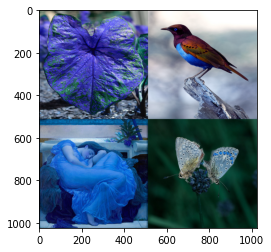

In [4]:
back=next(backGen)
plt.imshow(back)
plt.show()

(1024, 1024)


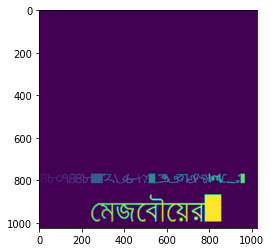

In [6]:
img,labels=createSceneImage(ds)
print(img.shape)
plt.imshow(img)
plt.show()

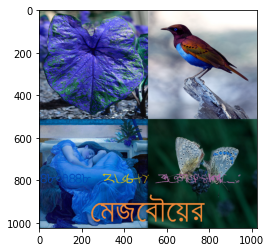

In [7]:
from coreLib.render import randColor
import random
for line_label in labels:
    # random choice for color distribution
    _colType=random.choice(["inline","different"])
    if _colType=="inline":
        line_col=randColor()
    else:
        line_col=None
    for label in line_label:
        # format color space
        if line_col is None:
            col=randColor()
        else:
            col=line_col
        # place colors
        for k,v in label.items():
            if v!=' ':
                back[img==k]=col
plt.imshow(back)
plt.show()
'''
img
back
labels
'''


In [30]:
def convertToTotalText(page,labels,rotations=None):
    '''
        **_label_mask:polygon
        ** text_lines[0]=
            "x: [[214 280 362 349 284 231]], y: [[325 290 320 347 316 346]], ornt: [u'c'], transcriptions: [u'ASRAMA']"
        @author
        create a function to convert page image to total text format data
        This should not depend on- 
            * language or 
            * type (handwritten/printed) or 
            * data(number/word/symbol)
        args:
            page   :     marked image of a page given at letter by letter 
            labels :     list of markings for each word
        returns:
            whatever is necessary for the total-text format
        FUTURE:
            * Rotation will be added after render class 
    '''
    # your code starts from here 
    # after finalization change returns segment under doc string above
    
    # char mask
    char_mask=np.zeros(page.shape)
    for line_labels in labels:
        for label in line_labels:
            for k,v in label.items():
                if v!=' ':
                    char_mask[page==k]=255

    char_mask=np.expand_dims(char_mask,axis=-1)
    char_mask=np.concatenate([char_mask,char_mask,char_mask],axis=-1)
    char_mask=char_mask.astype("uint8")
    # word_mask
    word_mask=np.zeros(page.shape)
    for line_labels in labels:
        for label in line_labels:
            _label_mask=np.zeros(img.shape)
            transcriptions=''
            for k,v in label.items():
                if v!=' ':
                    transcriptions+=v
                    idx = np.where(page==k)
                    y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])

                    word_mask[y_min:y_max+1,x_min:x_max+1]=255
                    _label_mask[y_min:y_max+1,x_min:x_max+1]=255
            plt.imshow(_label_mask)
            plt.show()
            print(transcriptions)
    word_mask=np.expand_dims(word_mask,axis=-1)
    word_mask=np.concatenate([word_mask,word_mask,word_mask],axis=-1)
    word_mask=word_mask.astype("uint8")
    # bounding box format text file
    text_lines=[]
    
    return char_mask,word_mask,text_lines

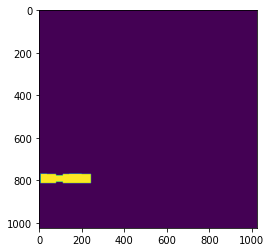

৪৮০৭৪৪৮


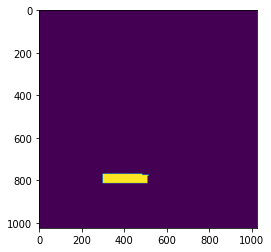

২৬৮৮>^


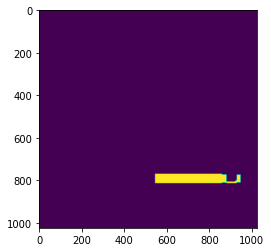

ক্সঞাগ্রুঠীর্লি[_,:


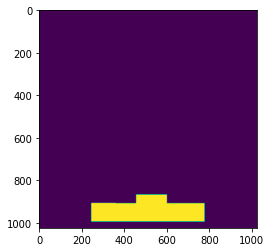

মেজবৌয়ের


In [31]:
cm,tm,_=convertToTotalText(img,labels)

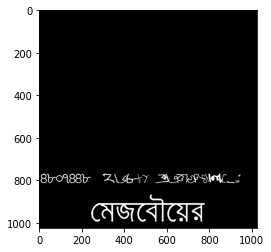

In [16]:
plt.imshow(cm)
plt.show()

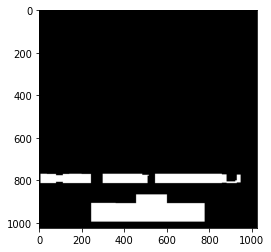

In [17]:
plt.imshow(tm)
plt.show()

# Rotation

In [3]:
ds.bangla.graphemes.df

,filename,label,img_path
0,Train_23740,র্ন্ত,/media/ansary/DriveData/Work/bengalAI/datasets...
1,Train_101878,স্ত,/media/ansary/DriveData/Work/bengalAI/datasets...
2,Train_5736,ল্ডো,/media/ansary/DriveData/Work/bengalAI/datasets...
3,Train_76463,গা,/media/ansary/DriveData/Work/bengalAI/datasets...
4,Train_158052,দু,/media/ansary/DriveData/Work/bengalAI/datasets...
...,...,...,...
200835,Train_129198,ফ্র্যা,/media/ansary/DriveData/Work/bengalAI/datasets...
200836,Train_175699,মা,/media/ansary/DriveData/Work/bengalAI/datasets...
200837,Train_38444,ঙ্গ,/media/ansary/DriveData/Work/bengalAI/datasets...
200838,Train_27077,দ্ভ,/media/ansary/DriveData/Work/bengalAI/datasets...


In [7]:
sorted(ds.bangla.graphemes.df.label.unique())

['ং',
 'ঃ',
 'অ',
 'অ্যা',
 'আ',
 'আঁ',
 'ই',
 'ইঁ',
 'ঈ',
 'উ',
 'উঁ',
 'ঊ',
 'ঋ',
 'এ',
 'এঁ',
 'এ্যা',
 'ঐ',
 'ও',
 'ঔ',
 'ক',
 'কা',
 'কাঁ',
 'কি',
 'কী',
 'কু',
 'কুঁ',
 'কূ',
 'কৃ',
 'কে',
 'কেঁ',
 'কৈ',
 'কো',
 'কৌ',
 'ক্ক',
 'ক্কা',
 'ক্কি',
 'ক্কে',
 'ক্কো',
 'ক্ট',
 'ক্টা',
 'ক্টি',
 'ক্টে',
 'ক্টো',
 'ক্ট্র',
 'ক্ট্রো',
 'ক্ত',
 'ক্তা',
 'ক্তি',
 'ক্তৃ',
 'ক্তে',
 'ক্তো',
 'ক্য',
 'ক্যা',
 'ক্যু',
 'ক্যে',
 'ক্র',
 'ক্রা',
 'ক্রি',
 'ক্রী',
 'ক্রু',
 'ক্রূ',
 'ক্রে',
 'ক্রো',
 'ক্র্যা',
 'ক্ল',
 'ক্লা',
 'ক্লি',
 'ক্লে',
 'ক্লো',
 'ক্ষ',
 'ক্ষা',
 'ক্ষি',
 'ক্ষী',
 'ক্ষু',
 'ক্ষে',
 'ক্ষো',
 'ক্ষৌ',
 'ক্ষ্ণ',
 'ক্ষ্ণৌ',
 'ক্ষ্ম',
 'ক্ষ্মী',
 'ক্ষ্য',
 'ক্ষ্যা',
 'ক্ষ্যে',
 'ক্স',
 'ক্সা',
 'ক্সি',
 'ক্সে',
 'খ',
 'খা',
 'খাঁ',
 'খি',
 'খী',
 'খু',
 'খুঁ',
 'খৃ',
 'খে',
 'খৈ',
 'খো',
 'খোঁ',
 'খ্য',
 'খ্যা',
 'খ্রি',
 'খ্রী',
 'গ',
 'গা',
 'গাঁ',
 'গি',
 'গী',
 'গু',
 'গুঁ',
 'গূ',
 'গৃ',
 'গে',
 'গেঁ',
 'গৈ',
 'গো',
 'গোঁ',
 'গৌ',
 'গ্ধ',
 'গ্ধা',
 'গ্ন',
 'গ্না',
 'গ্নি',
 

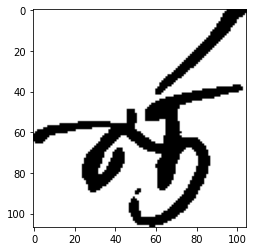

In [6]:
plt.imshow(cv2.imread(ds.bangla.graphemes.df.iloc[0,2],0),cmap="gray")
plt.show()

In [9]:
img=cv2.imread(ds.bangla.graphemes.df.iloc[0,2],0)
np.where(img==0)

(array([  0,   0,   0, ..., 106, 106, 106]),
 array([95, 96, 97, ..., 57, 58, 59]))

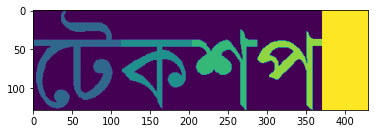

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import numpy as np
iden=2
from coreLib.word import create_word
img,label,iden=create_word(iden,
                            "bangla",
                            "printed",
                            "grapheme",
                            ds,
                            use_dict=True)
# max neutralization
plt.imshow(img)
plt.show()


In [ ]:
def padImg(line_img,h_max,w_max):
    # shape
    h,w=line_img.shape
    # pad widths
    left_pad_width =(w_max-w)//2   # <<<<<<<<==========
    # print(left_pad_width)
    right_pad_width=w_max-w-left_pad_width   # <<<<<<<<==========
    # pads
    left_pad =np.zeros((h,left_pad_width))
    right_pad=np.zeros((h,right_pad_width))
    # pad
    line_img =np.concatenate([left_pad,line_img,right_pad],axis=1)
    
    # shape
    h,w=line_img.shape
    # pad heights
    top_pad_height =(h_max-h)//2
    bot_pad_height=h_max-h-top_pad_height
    # pads
    top_pad =np.zeros((top_pad_height,w))
    bot_pad=np.zeros((bot_pad_height,w))
    # pad
    line_img =np.concatenate([top_pad,line_img,bot_pad],axis=0)
    return line_img

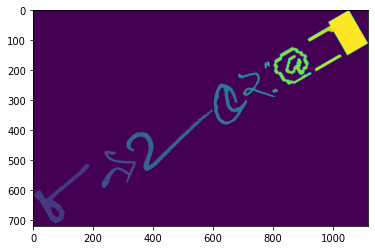

{2: '৮', 3: '৯', 4: '২', 5: '৫', 6: '২', 7: '.', 8: "'", 9: "'", 10: '@', 11: '=', 12: ' '}


In [22]:
def rotate_image(mat, angle):
    """
        Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),flags=cv2.INTER_NEAREST)
    return rotated_mat,rotation_mat


rotated_img,M=rotate_image(img,30)
plt.imshow(rotated_img)
plt.show()
print(label)
#_img=cv2.resize(_img,(width,font_size)),fx=0,fy=0, interpolation = cv2.INTER_NEAREST)

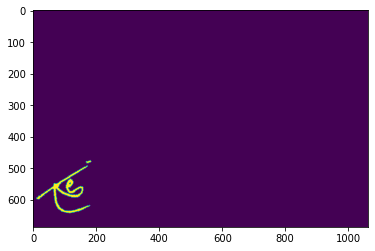

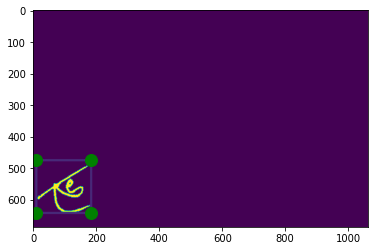

In [13]:
# back=np.zeros(rotated_img.shape)
# back[rotated_img==2]=255
# plt.imshow(back)
# plt.show()
# # co-ordinate
# idx = np.where(back==255)
# y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
# x1,x2,x3,x4=x_min,x_max,x_max,x_min
# y1,y2,y3,y4=y_min,y_min,y_max,y_max
# coords=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32")

# single = cv2.rectangle(back, (x1,y1), (x3,y3), 30, 5)
# plt.plot(x1, y1, 'go--', linewidth=2, markersize=12)
# plt.plot(x2, y2, 'go--', linewidth=2, markersize=12)
# plt.plot(x3, y3, 'go--', linewidth=2, markersize=12)
# plt.plot(x4, y4, 'go--', linewidth=2, markersize=12)
# plt.imshow(single)
# plt.show()

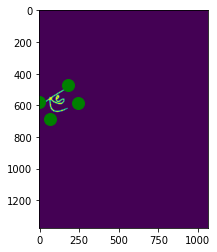

In [19]:
# back=np.zeros(rotated_img.shape)
# back[rotated_img==2]=255
# back=np.concatenate([back,np.zeros(bach,w=img.shape
          if w>w_max:
            w_max=w

          imgs.append(img)
          labels.append(label)


        w_max+=32
        padded=[]
        for img in imgs:
          img=padImg(img,h_max,w_max) ### <<<<<================= Call Function
          padded.append(img)
k.shape)],axis=0)
# # co-ordinate
# idx = np.where(img==2)
# y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
# x1,x2,x3,x4=x_min,x_max,x_max,x_min
# y1,y2,y3,y4=y_min,y_min,y_max,y_max
# coords=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32")

# new_coords=[]
# coord_mat=np.concatenate([coords,np.ones((4,1))],axis=1)
# for c in coord_mat:
#     new_coords.append(np.dot(M,c))

# plt.imshow(back)
# for c in new_coords:
#     plt.plot(c[0], c[1], 'go--', linewidth=2, markersize=12)

# plt.show()


